In [1]:
import os

os.chdir("/workspaces/example_digital-twin_incubator_twright/software/incubator")

In [2]:
import sys

sys.path.append("/workspaces/example_digital-twin_incubator_twright/software")

In [3]:
import matplotlib.pyplot as plt

In [4]:
from digital_twin.simulator.verified_plant_simulator import VerifiedPlantMonitor4Params

In [5]:
from verified_twin.lbuc import *
import sage.all as sg
from sage.all import RIF

In [6]:
sg.var("T_A", "T_H")

(T_A, T_H)

In [7]:
plt.rcParams['figure.figsize'] = [60/2.54, 30/2.54]

In [8]:
from incubator.tests.self_adaptation_tests.test_self_adaptation import *

/home/sage/sage/local/lib/python3.9/site-packages/control/xferfcn.py:1498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(data[i][j][k], (int, np.int)):


In [9]:
import numpy as np
from oomodelling import Model

from incubator.calibration.calibrator import Calibrator
from incubator.self_adaptation.controller_optimizer import IControllerOptimizer
from incubator.interfaces.updateable_kalman_filter import IUpdateableKalmanFilter

In [10]:
from digital_twin.calibration.uncertainty_calibrator import UncertaintyCalibrator

In [11]:
from incubator.self_adaptation.supervisor import SupervisorNOOPSM

In [12]:
properties = [
    F(RIF(0,1000), G(RIF(0, 100),
        Atomic(T_A < RIF(46)) & Atomic(T_A > RIF(36)))),
    G(RIF(0, 1000), Atomic(T_A < RIF(60))),
    G(RIF(0, 1000), Atomic(T_H < RIF(65))),
]

## Self-Adaptation Loop Integration

In [13]:
config = load_config("startup.conf")

n_samples_period = 40
n_samples_heating = 5
C_air = config["digital_twin"]["models"]["plant"]["param4"]["C_air"]
G_box = config["digital_twin"]["models"]["plant"]["param4"]["G_box"]
G_box_kf = G_box
C_heater = config["digital_twin"]["models"]["plant"]["param4"]["C_heater"]
G_heater = config["digital_twin"]["models"]["plant"]["param4"]["G_heater"]
initial_box_temperature = 41
initial_heat_temperature = 47
initial_room_temperature = 21  # TODO: Add this parameter to config file.
std_dev = 0.001
step_size = 3.0
anomaly_threshold = 2.0
# Time spent before declaring that there is an self_adaptation_manager, after the first time the self_adaptation_manager occurred.
ensure_anomaly_timer = 1
# Time spent, after the self_adaptation_manager was declared as detected, just so enough data about the system is gathered.
# The data used for recalibration will be in interval [time_first_occurrence, time_data_gathered]
gather_data_timer = 20
cool_down_timer = 5
optimize_controller = True

conv_xatol = 0.1
conv_fatol = 0.1
max_iterations = 200
desired_temperature = 41
max_t_heater = 60
restrict_T_heater = True

# Supervisor parameters
trigger_optimization_threshold = 10.0
heater_underused_threshold = 10.0
wait_til_supervising_timer = 100  # N steps supervisor should wait before kicking in.

tf = 3000

kalman = KalmanFilter4P(step_size, std_dev,
                        C_air, G_box_kf, C_heater, G_heater,
                        initial_room_temperature, initial_heat_temperature, initial_box_temperature)

database = MockDatabase(step_size)
plant_simulator = PlantSimulator4Params()
calibrator = Calibrator(database, plant_simulator, conv_xatol, conv_fatol, max_iterations)
pt_simulator = SystemModel4ParametersOpenLoopSimulator()
ctrl = MockController()

verified_monitor = VerifiedPlantMonitor4Params(properties)
uncertainty_calibrator = UncertaintyCalibrator(database)

if optimize_controller:
    ctrl_optimizer = ControllerOptimizer(database, pt_simulator, ctrl, conv_xatol, conv_fatol, max_iterations, restrict_T_heater, desired_temperature, max_t_heater)
else:
    ctrl_optimizer = NoOPControllerOptimizer()

anomaly_detector = SelfAdaptationManager(anomaly_threshold, ensure_anomaly_timer, gather_data_timer, cool_down_timer,
                                         calibrator, kalman, ctrl_optimizer,
                                         verified_monitor,
                                         uncertainty_calibrator,
                                         lookahead_time=500.0)
# supervisor = SupervisorPeriodicSM(ctrl_optimizer, wait_til_supervising_timer)
# Should the supervisor also trigger verified monitoring
supervisor = SupervisorNOOPSM()
# supervisor = SupervisorThresholdSM(ctrl_optimizer, desired_temperature, max_t_heater,
#                                    trigger_optimization_threshold, heater_underused_threshold,
#                                    wait_til_supervising_timer)

m = SelfAdaptationScenario(n_samples_period, n_samples_heating,
                           C_air, G_box, C_heater, G_heater,
                           initial_box_temperature,
                           initial_heat_temperature,
                           initial_room_temperature,
                           kalman, anomaly_detector, supervisor,
                           std_dev)

# Inform mock db of plant _plant.
database.set_models(m.physical_twin.plant, m.physical_twin.ctrl)
# Inform mock of controller
ctrl.set_model(m.physical_twin.ctrl)

# Wire in a custom function for the G_box input, so we can change it.
m.physical_twin.plant.G_box = lambda: G_box if m.time() < 500 else (G_box * 10 if m.time() < 1500 else G_box)

# Wire in a custom function for the C_air parameter,
# so we mimick a different object being placed in the incubator.
# Commented out because it does not seem to work very well.
# m.physical_twin.plant.C_air = lambda: C_air if m.time() < 1000 else (C_air * 7 if m.time() < 2000 else C_air)

ModelSolver().simulate(m, 0.0, tf, 3.0)

/home/sage/sage/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


running uncertainty calibration for anomaly between times 504.5938409201124 and 567.5938409201124





running verified monitoring for anomaly between times 504.5938409201124 and 567.5938409201124
ran verified simulation in 104.0481948852539 sec
mask for F = None
In G.signal
mask for G = None
and mask = None
and sig = None
and mask = None
and sig = None
In G.signal
mask for G = None
In G.signal
mask for G = None
running uncertainty calibration for anomaly between times 1515.5938409201124 and 1578.5938409201124






































running verified monitoring for anomaly between times 1515.5938409201124 and 1578.5938409201124
ran verified simulation in 91.97104978561401 sec
mask for F = None
In G.signal
mask for G = None
and mask = None
and sig = None
and mask = None
and sig = None
In G.signal
mask for G = None
In G.signal
mask for G = None
running uncertainty calibration for anomaly between times 1605.5938409201124 and 1668.5938409201124



















running veri

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 6026
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
       2.99459384e+03, 2.99759384e+03, 3.00000000e+03])
 t_events: None
        y: array([[0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        2.99459384e+03, 2.99759384e+03, 3.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        2.99459384e+03, 2.99759384e+03, 3.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        2.99459384e+03, 2.99759384e+03, 3.00000000e+03],
       ...,
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        2.99459384e+03, 2.99759384e+03, 3.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        2.99459384e+03, 2.99759384e+03, 3.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        2.9945

In [14]:
G(RIF(5,10), Atomic(T_H)).duration

10.0000000000000

In [15]:
m.self_adaptation_manager.state_machine.anomaly_durations

[(504.5938409201124, 567.5938409201124),
 (1515.5938409201124, 1578.5938409201124),
 (1605.5938409201124, 1668.5938409201124)]

In [16]:
# m.supervisor.state_machine.supervisor_trigger_times

In [17]:
m.self_adaptation_manager.state_machine.anomaly_parameters

[(570.5938409201124,
  1070.5938409201124,
  26.?,
  43.?,
  21,
  3.0,
  40,
  16,
  146.?,
  8.?,
  227.76228512,
  1.92343277),
 (1581.5938409201124,
  2081.5938409201126,
  4.?e1,
  64.?,
  21,
  3.0,
  40,
  0,
  161.?,
  1.?,
  227.76228512,
  1.92343277),
 (1671.5938409201124,
  2171.5938409201126,
  46.?,
  55.?,
  21,
  3.0,
  40,
  5,
  146.?,
  0.8?,
  227.76228512,
  1.92343277)]

In [18]:
m.self_adaptation_manager.state_machine.verified_monitoring_results

[[(False,
   Signal([570.59384092011237 .. 2170.5938409201126], [([570.59384092011237 .. 1170.5938409201126], False)], mask=None)),
  (True,
   Signal([570.59384092011237 .. 2170.5938409201126], [([570.59384092011237 .. 1170.5938409201126], True)], mask=None)),
  (True,
   Signal([570.59384092011237 .. 2170.5938409201126], [([570.59384092011237 .. 1170.5938409201126], True)], mask=None))],
 [(True,
   Signal([1581.5938409201123 .. 3181.5938409201126], [([1581.5938409201123 .. 1846.9937070245965], True), ([2051.9477641008766 .. 2181.5938409201126], False)], mask=None)),
  (True,
   Signal([1581.5938409201123 .. 3181.5938409201126], [([1581.5938409201123 .. 2181.5938409201126], True)], mask=None)),
  (True,
   Signal([1581.5938409201123 .. 3181.5938409201126], [([1581.5938409201123 .. 2181.5938409201126], True)], mask=None))],
 [(True,
   Signal([1671.5938409201123 .. 3271.5938409201126], [([1671.5938409201123 .. 3171.5938409201126], True)], mask=None)),
  (True,
   Signal([1671.59384092

### Experiment outcome

In [19]:
plt.rcParams['figure.figsize'] = [18/2.54, 9/2.54]

Parameters:
C_air:  [145.69782402, 145.7118861841649, 160.31905093155763, 145.68655593943595]
G_box:  [0.79154106, 7.915515535380671, 0.662057557747993, 0.7915079892676193]
C_heater:  [227.76228512, 227.76228512, 227.76228512, 227.76228512]
G_heater:  [1.92343277, 1.92343277, 1.92343277, 1.92343277]


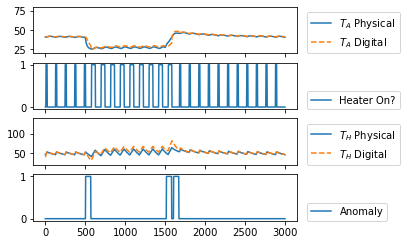

In [20]:
plt.rcParams['figure.figsize'] = [12/2.54, 10/2.54]

fig, (ax1, ax2, ax3, ax5) = plt.subplots(4, 1, sharex='all')

legend_opts = dict(loc=(1.04,0))

ax1.plot(m.signals['time'], m.physical_twin.plant.signals['T'], label=f"$T_A$ Physical")
ax1.plot(m.signals['time'], m.kalman.signals['out_T'], linestyle="dashed", label=f"$T_A$ Digital")
# ax1.plot(m.signals['time'], m.kalman.signals['out_T_prior'], linestyle="dashed", label=f"~ T_prior")

# for (times, trajectory) in database.plant_calibration_trajectory_history:
#    ax1.plot(times, trajectory[0, :], label=f"cal T", linestyle='dotted')

#for (times, T, T_heater, heater_on) in database.ctrl_optimal_policy_history:
#    ax1.plot(times, T, label=f"opt T", linestyle='dotted')
ax1.set_ylim([20, 80])
ax1.legend(**legend_opts)

ax2.plot(m.signals['time'], [(1 if b else 0) for b in m.physical_twin.ctrl.signals['heater_on']], label=f"Heater On?")
# ax2.plot(m.signals['time'], [(1 if b else 0) for b in m.kalman.signals['in_heater_on']], linestyle="dashed", label=f"heater_on")

ax2.legend(**legend_opts)

ax3.plot(m.signals['time'], m.physical_twin.plant.signals['T_heater'], label=f"$T_H$ Physical")
ax3.plot(m.signals['time'], m.kalman.signals['out_T_heater'], linestyle="dashed", label=f"$T_H$ Digital")
ax3.set_ylim([20, 140])

ax3.legend(**legend_opts)

# The following plot is incorrect, since it does not match with the actual residual computed by the self_adaptation_manager
# ax4.scatter(m.signals['time'],
#             np.absolute(np.array(m.physical_twin.plant.signals['T']) - np.array(m.kalman.signals['out_T'])),
#             label=f"Error")

# ax4.scatter(m.signals['time'],
#             m.self_adaptation_manager.signals["temperature_residual_abs"],
#             label=f"Error")
# ax4.legend(**legend_opts)

ax5.plot(m.signals['time'],
         [(1
           if any(t in RIF(*p)
                  for p
                  in m.self_adaptation_manager.state_machine.anomaly_durations) 
           else 0)
           for t in m.signals['time']],
         label='Anomaly')
ax5.legend(**legend_opts)

#ax5.plot(m.signals['time'], m.kalman.signals['out_P_00'], label=f"P_00")
#ax5.plot(m.signals['time'], m.kalman.signals['out_P_11'], label=f"P_11")

#ax5.legend()

#ax6.plot(m.signals['time'], m.kalman.signals['C_air'], label=f"C_air")
#ax6.plot(m.signals['time'], m.kalman.signals['G_box'], label=f"G_box")

#ax6.legend()

print("Parameters:")
print("C_air: ", database.C_air)
print("G_box: ", database.G_box)
print("C_heater: ", database.C_heater)
print("G_heater: ", database.G_heater)
plt.savefig("fixed-self-adaptation-behaviour.pdf", bbox_inches="tight")
plt.show()

In [30]:
sg.table([
    [c[0] for c in r]
    for r in m.self_adaptation_manager.state_machine.verified_monitoring_results      
]).transpose()

  False   True   True
  True    True   True
  True    True   True

### Manually do some verified simulation for anomolies

#### Anomaly 1

In [21]:
m.self_adaptation_manager.state_machine.anomaly_durations[0]

(504.5938409201124, 567.5938409201124)

In [22]:
m.self_adaptation_manager.state_machine.anomaly_parameters[0]

(570.5938409201124,
 1070.5938409201124,
 26.?,
 43.?,
 21,
 3.0,
 40,
 16,
 146.?,
 8.?,
 227.76228512,
 1.92343277)

In [27]:
verified_trace1, verified_model1 = VerifiedPlantMonitor4Params.run_simulation(*m.self_adaptation_manager.state_machine.anomaly_parameters[0])
verified_sigs1 = m.self_adaptation_manager.state_machine.verified_monitoring_results[0]

ran verified simulation in 19.746987104415894 sec


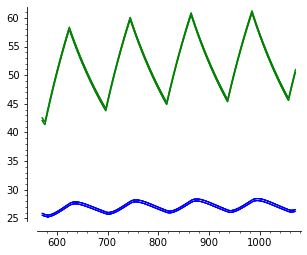

In [28]:
p1 = verified_trace1.plot(('T_A', 'T_H'), color=('blue', 'green')); p1.matplotlib()

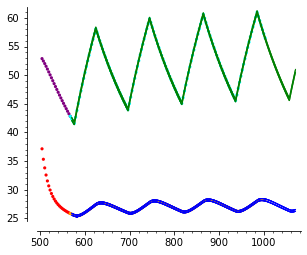

In [29]:
(p1 + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T_heater'])
     if t
     in RIF(*m.self_adaptation_manager.state_machine.anomaly_durations[0])],
    color='purple',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T_heater'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[0][1],
            m.self_adaptation_manager.state_machine.anomaly_durations[0][0] + 500)],
    color='cyan',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T'])
     if t
     in RIF(*m.self_adaptation_manager.state_machine.anomaly_durations[0])],
    color='red',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[0][1],
            m.self_adaptation_manager.state_machine.anomaly_durations[0][0] + 500)],
    color='orange',
)
).matplotlib()

In [26]:
p11 = (verified_sigs1[0].plot(y_range=(30, 65)) + p1)
p11.set_aspect_ratio('auto')
p11.matplotlib()

AttributeError: 'tuple' object has no attribute 'plot'

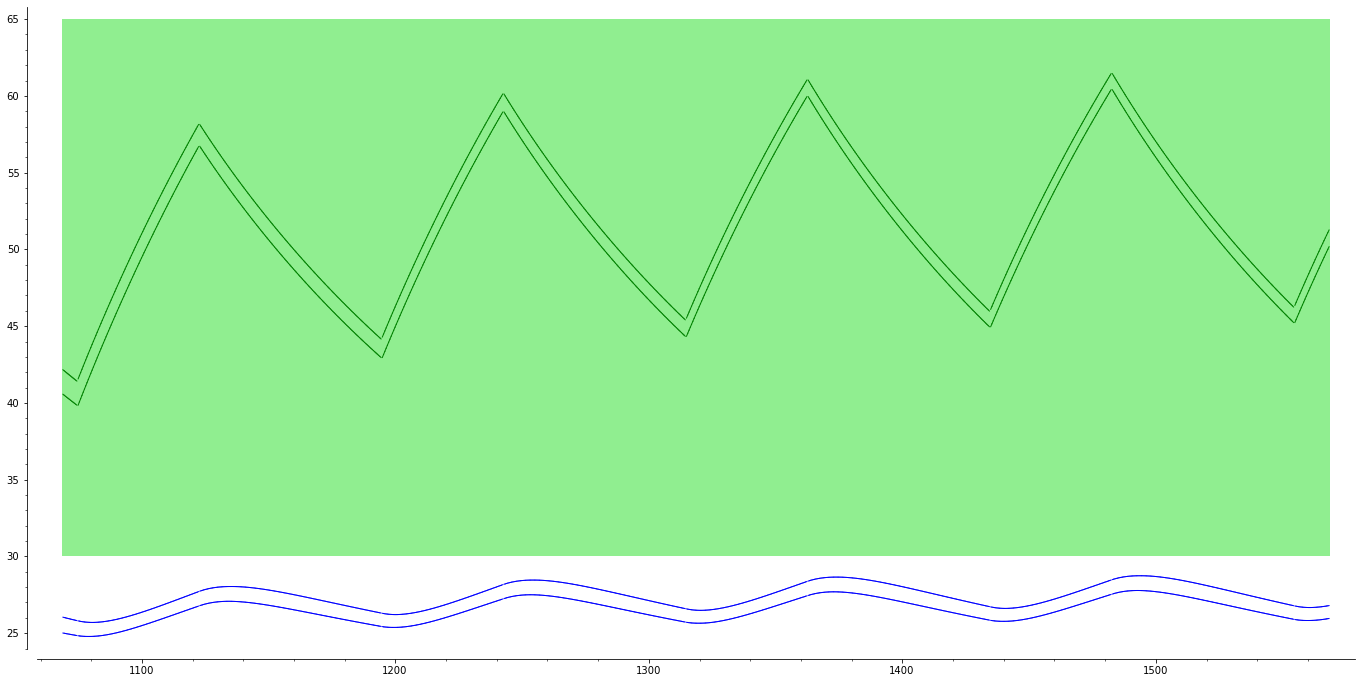

In [ ]:
p12 = (verified_sigs1[1].plot(y_range=(30, 65)) + p1)
p12.set_aspect_ratio('auto')
p12.matplotlib()

In [ ]:
p13 = (verified_sigs1[3].plot(y_range=(30, 65)) + p1)
p13.set_aspect_ratio('auto')
p13.matplotlib()

### Anomoly 2

In [ ]:
m.self_adaptation_manager.state_machine.anomaly_parameters[1]

(2082.593840920112,
 2582.593840920112,
 4.?e1,
 7.?e1,
 21,
 3.0,
 40,
 0,
 172.?,
 0.6?,
 227.76228512,
 1.92343277)

In [31]:
verified_trace2, verified_model2 = VerifiedPlantMonitor4Params.run_simulation(*m.self_adaptation_manager.state_machine.anomaly_parameters[1])
verified_sigs2 = m.self_adaptation_manager.state_machine.verified_monitoring_results[1]

ran verified simulation in 18.16118860244751 sec


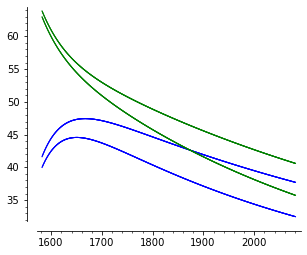

In [32]:
p2 = verified_trace2.plot(('T_A', 'T_H'), color=('blue', 'green')); p2.matplotlib()

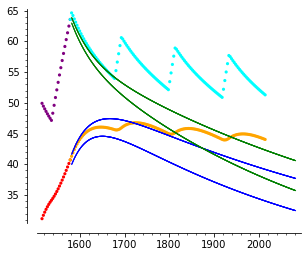

In [33]:
(p2 + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T_heater'])
     if t
     in RIF(*m.self_adaptation_manager.state_machine.anomaly_durations[1])],
    color='purple',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T_heater'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[1][1],
            m.self_adaptation_manager.state_machine.anomaly_durations[1][0] + 500)],
    color='cyan',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T'])
     if t
     in RIF(*m.self_adaptation_manager.state_machine.anomaly_durations[1])],
    color='red',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[1][1],
            m.self_adaptation_manager.state_machine.anomaly_durations[1][0] + 500)],
    color='orange',
)
).matplotlib()

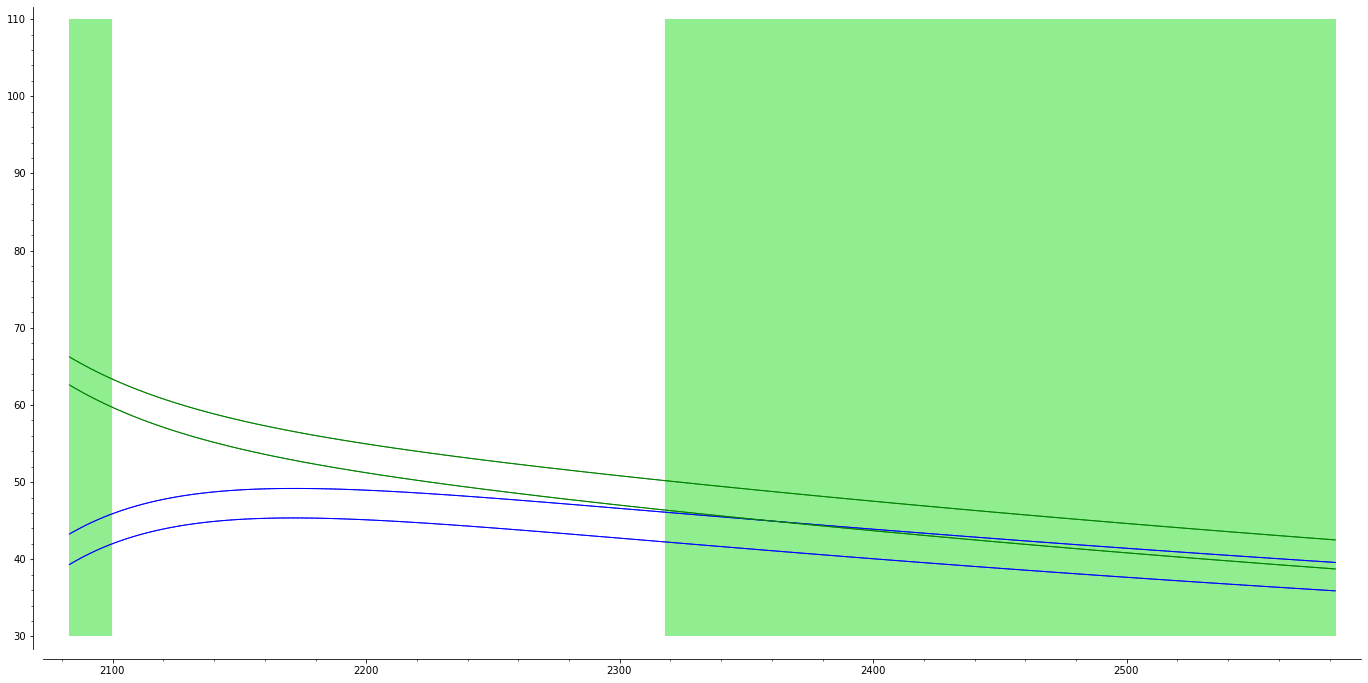

In [ ]:
p21 = (verified_sigs2[0].plot(y_range=(30, 110)) + p2)
p21.set_aspect_ratio('auto')
p21.matplotlib()

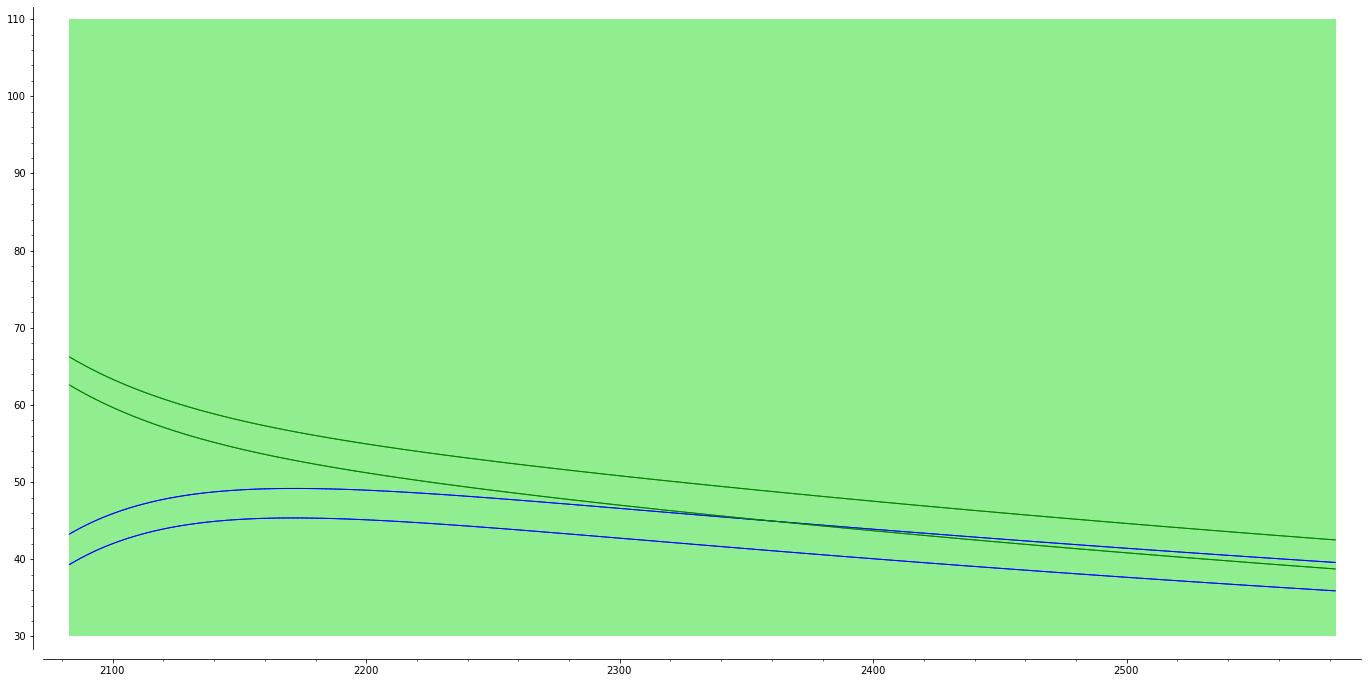

In [ ]:
p22 = (verified_sigs2[1].plot(y_range=(30, 110)) + p2)
p22.set_aspect_ratio('auto')
p22.matplotlib()

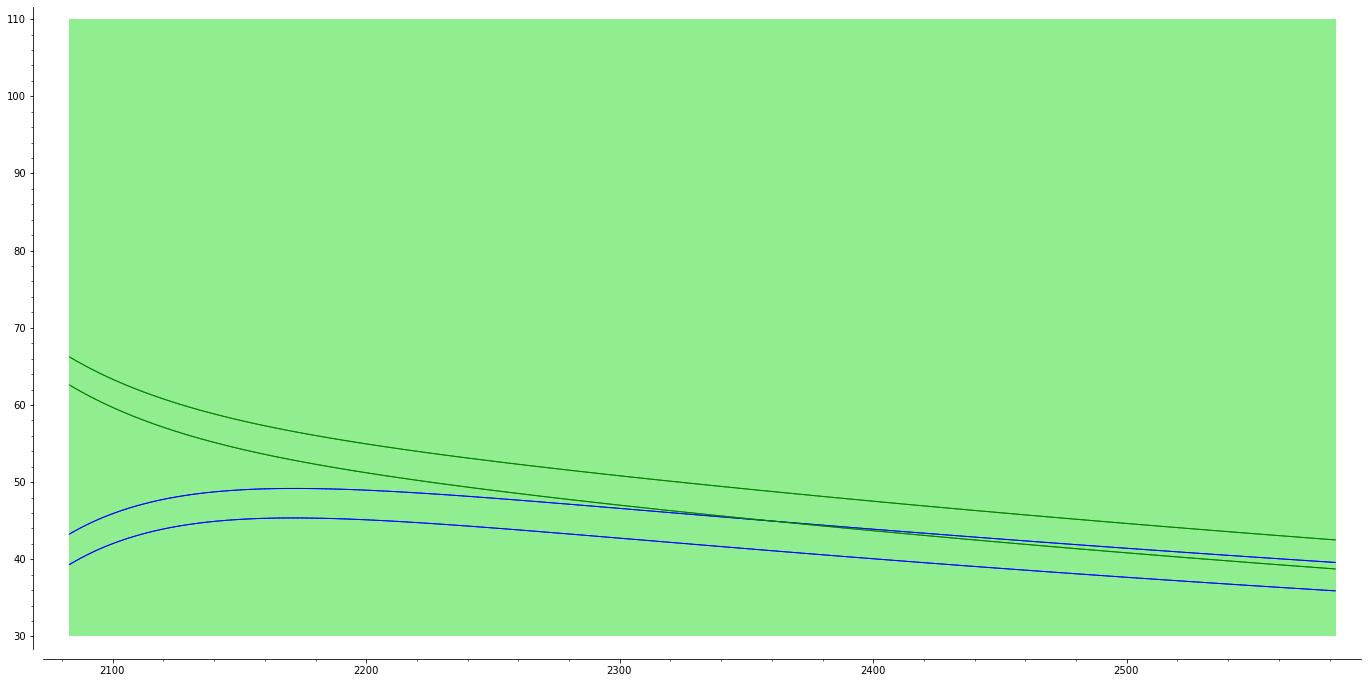

In [ ]:
p23 = (verified_sigs2[1].plot(y_range=(30, 110)) + p2)
p23.set_aspect_ratio('auto')
p23.matplotlib()

#### Anomoly 3

In [ ]:
m.self_adaptation_manager.state_machine.anomaly_parameters[2]

(2178.593840920112,
 2678.593840920112,
 5.?e1,
 6.?e1,
 21,
 3.0,
 40,
 5,
 1.5?e2,
 0.8?,
 227.76228512,
 1.92343277)

In [34]:
verified_trace3, verified_model3 = VerifiedPlantMonitor4Params.run_simulation(*m.self_adaptation_manager.state_machine.anomaly_parameters[2])
verified_sigs3 = m.self_adaptation_manager.state_machine.verified_monitoring_results[2]

ran verified simulation in 18.774195194244385 sec


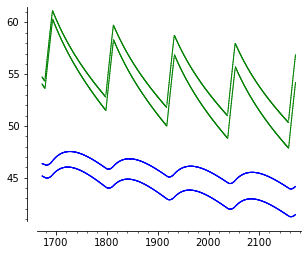

In [35]:
p3 = verified_trace3.plot(('T_A', 'T_H'), color=('blue', 'green')); p3.matplotlib()

In [ ]:
m.self_adaptation_manager.state_machine.anomaly_durations[2]

(2112.593840920112, 2175.593840920112)

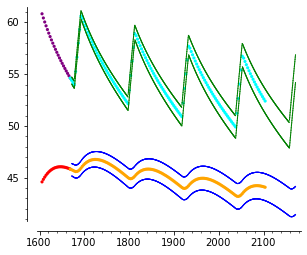

In [36]:
g = (p3 + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T_heater'])
     if t
     in RIF(*m.self_adaptation_manager.state_machine.anomaly_durations[2])],
    color='purple',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T_heater'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[2][1],
            m.self_adaptation_manager.state_machine.anomaly_durations[2][0] + 500)],
    color='cyan',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T'])
     if t
     in RIF(*m.self_adaptation_manager.state_machine.anomaly_durations[2])],
    color='red',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[2][1],
            m.self_adaptation_manager.state_machine.anomaly_durations[2][0] + 500)],
    color='orange',
)
)
g.matplotlib()

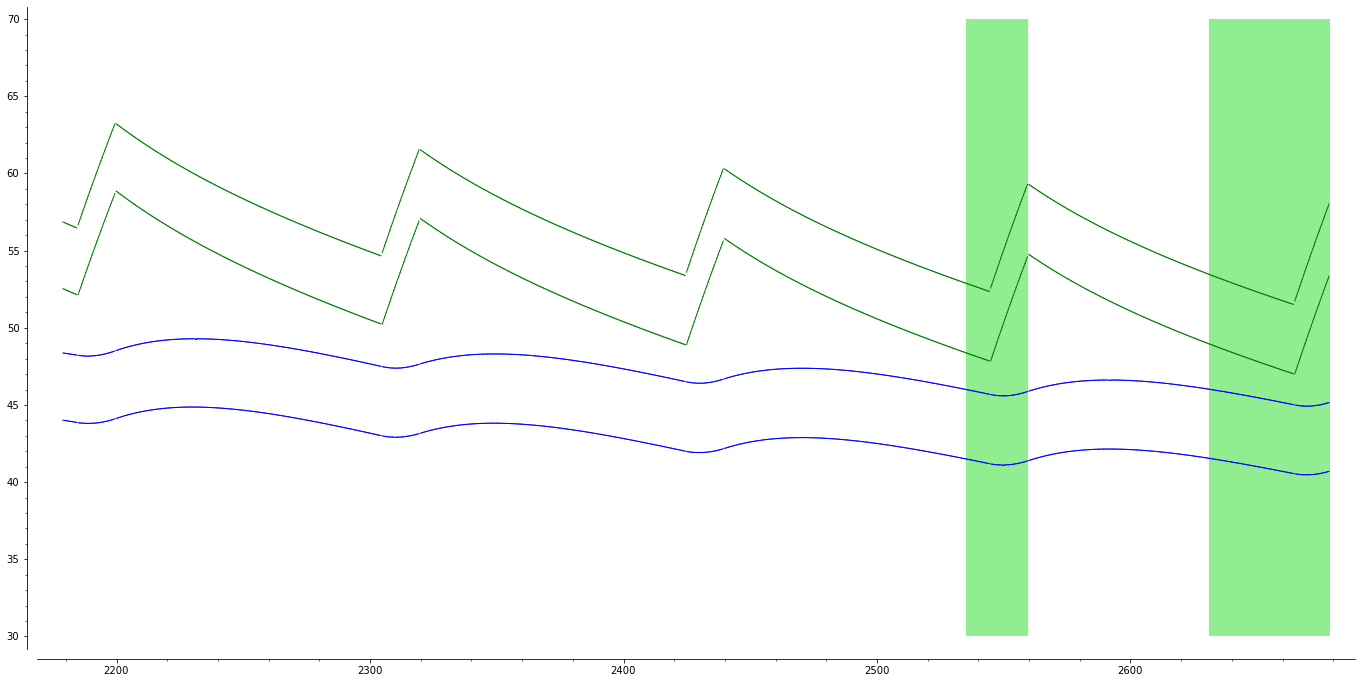

In [ ]:
p31 = (verified_sigs3[0].plot(y_range=(30, 70)) + p3)
p31.set_aspect_ratio('auto')
p31.matplotlib()

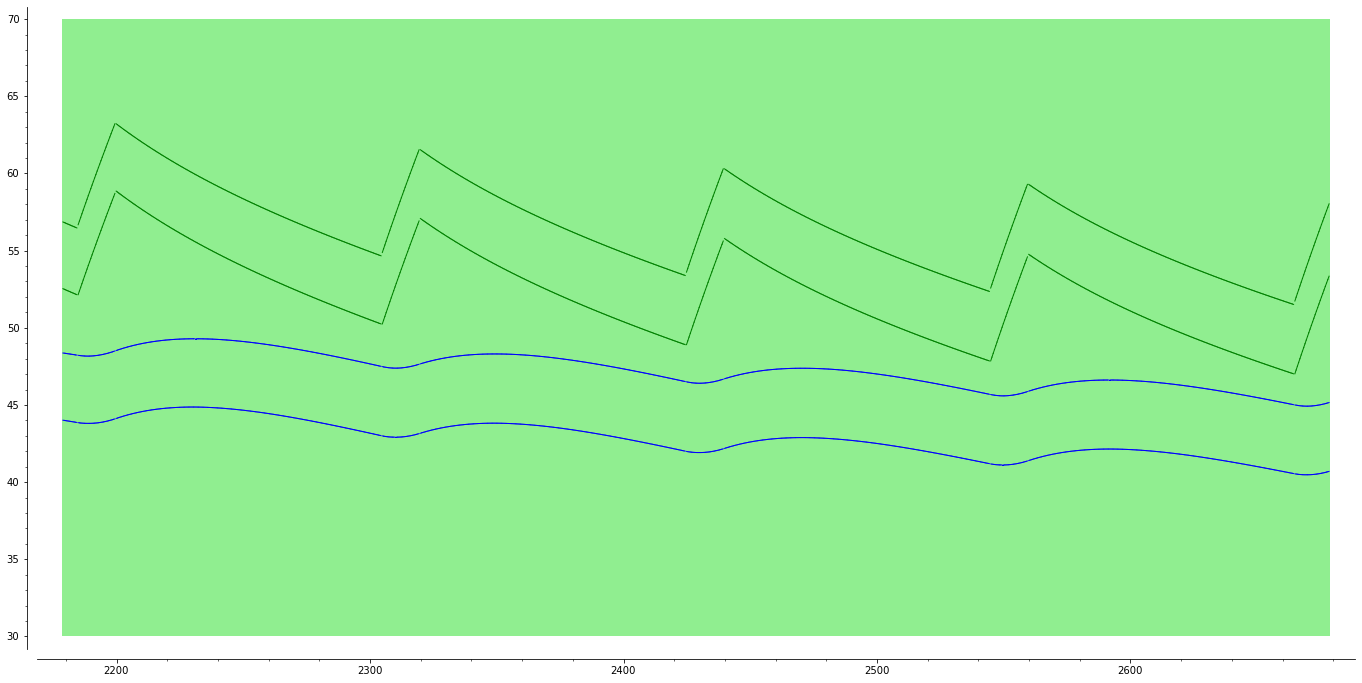

In [ ]:
p32 = (verified_sigs3[1].plot(y_range=(30, 70)) + p3)
p32.set_aspect_ratio('auto')
p32.matplotlib()

In [ ]:
m.self_adaptation_manager.state_machine.uncertainty_calibration_parameters

[(1002.5938409201124,
  1065.5938409201124,
  145.7277103883956,
  7.916405196852278,
  227.76228512,
  1.92343277),
 (2016.5938409201124,
  2079.593840920112,
  171.83974995480446,
  0.5437528169825697,
  227.76228512,
  1.92343277),
 (2112.593840920112,
  2175.593840920112,
  145.74219292617187,
  0.7914890608326322,
  227.76228512,
  1.92343277)]

In [ ]:
m.self_adaptation_manager.state_machine.anomaly_predicted_temperatures

[40.97175112539478,
 40.96878978340622,
 40.997389310191146,
 41.062595796731514,
 41.16548666580619,
 41.30526946128608,
 41.4303112448622,
 41.54401966431516,
 41.64624864241599,
 41.73718022225467,
 41.81716576087568,
 41.88663523967537,
 41.94604687733138,
 41.99586072834831,
 42.036526264092565,
 42.06847774556069,
 42.092133597345246,
 42.10789753446743,
 42.11616018336525,
 42.117300559999414,
 42.11168714287171,
 42.09967849031658,
 42.08162345836524,
 42.05786111852677,
 42.02872048150174,
 41.99452012099434,
 41.95556777240387,
 41.912159960550404,
 41.86458169195928,
 41.81310623194749,
 41.757994975088266,
 41.69949740928331,
 41.63785116810771,
 41.57328216271541,
 41.50600478284846,
 41.43622215590791,
 41.36412645323917,
 41.28989923346939,
 41.21371181369645,
 41.1357256604171,
 41.05609279319425,
 41.024913650617975,
 41.03639018016498,
 41.08865693956001,
 41.1798377512451,
 41.30806066206675,
 41.421494247073184,
 41.52424413438429,
 41.61651571369168,
 41.6985571525

In [ ]:
m.self_adaptation_manager.state_machine.anomaly_real_temperatures

[40.89343413361608,
 40.803435217455856,
 40.73871379305887,
 40.734045186209215,
 40.78474185264556,
 40.88646379137607,
 41.03518939641186,
 41.20108342804741,
 41.34601857965197,
 41.471576450635816,
 41.57921916781574,
 41.6703018796663,
 41.74608056593099,
 41.80771927721309,
 41.85629684615125,
 41.8928131087482,
 41.91819467160574,
 41.9333002582099,
 41.93892566499064,
 41.935808355638365,
 41.924631720080185,
 41.90602902259222,
 41.88058706173731,
 41.84884956316178,
 41.811320324749445,
 41.768466132208054,
 41.720719461844006,
 41.66848098605819,
 41.61212189596214,
 41.55198605446262,
 41.48839199218861,
 41.421634757731425,
 41.351987632831424,
 41.27970372236881,
 41.20501742829637,
 41.12814581598512,
 41.049289880835495,
 40.96863572243368,
 40.88635563300118,
 40.802609106393334,
 40.717543773445804,
 40.631296269044874,
 40.57010181659183,
 40.5687518551728,
 40.62257377919854,
 40.727241437446075,
 40.87874606426172,
 41.0472643245109,
 41.194679948661836,
 41.32258

#### Anomoly 4

In [ ]:

m.self_adaptation_manager.state_machine.anomaly_parameters[3]

IndexError: list index out of range

In [ ]:
params = m.self_adaptation_manager.state_machine.anomaly_parameters[3]

In [ ]:
params[0:6]

(2112.593840920112, 2612.593840920112, 5.?e1, 6.?e1, 21, 3.0)

In [ ]:
params1 = params[0:6] + (params[7], params[6]) + params[8:]

In [ ]:

verified_trace4, verified_model4 = VerifiedPlantMonitor4Params.run_simulation(*params)

ran verified simulation in 21.01648736000061 sec


In [ ]:
verified_sigs4 = m.self_adaptation_manager.state_machine.verified_monitoring_results[3]


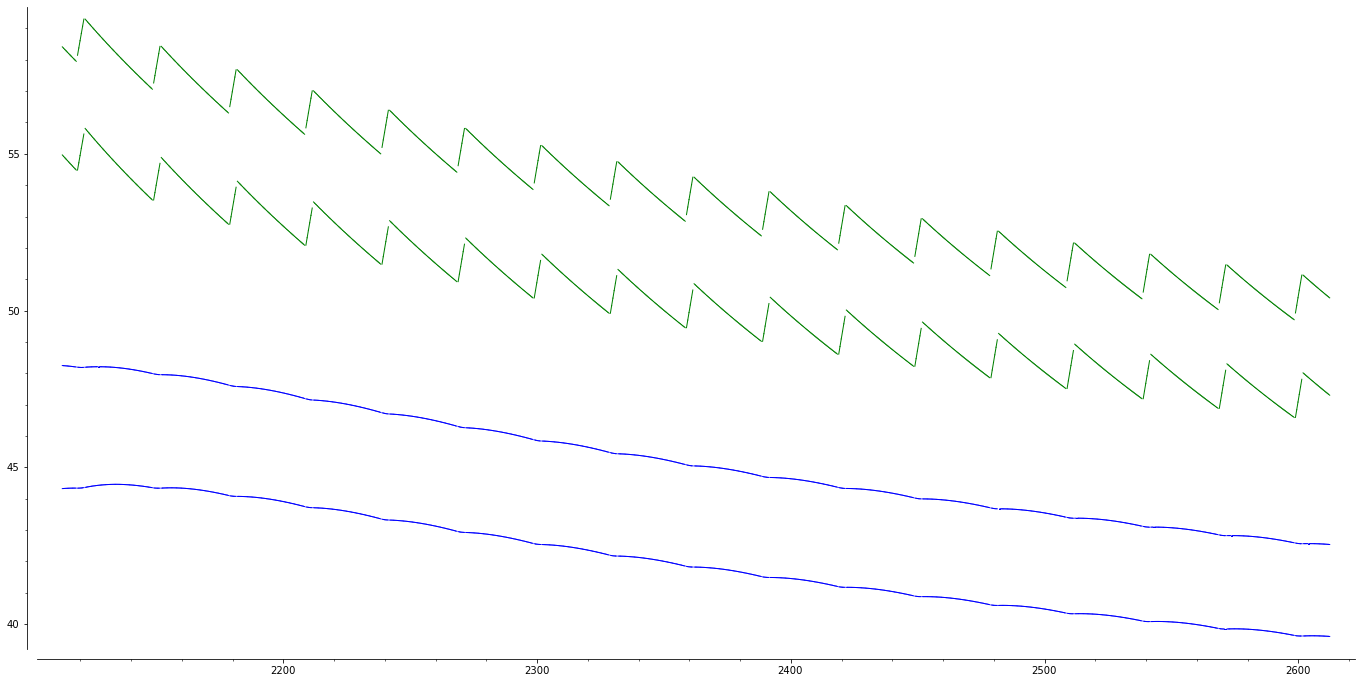

In [ ]:
p4 = verified_trace4.plot(('T_A', 'T_H'), color=('blue', 'green')); p4.matplotlib()

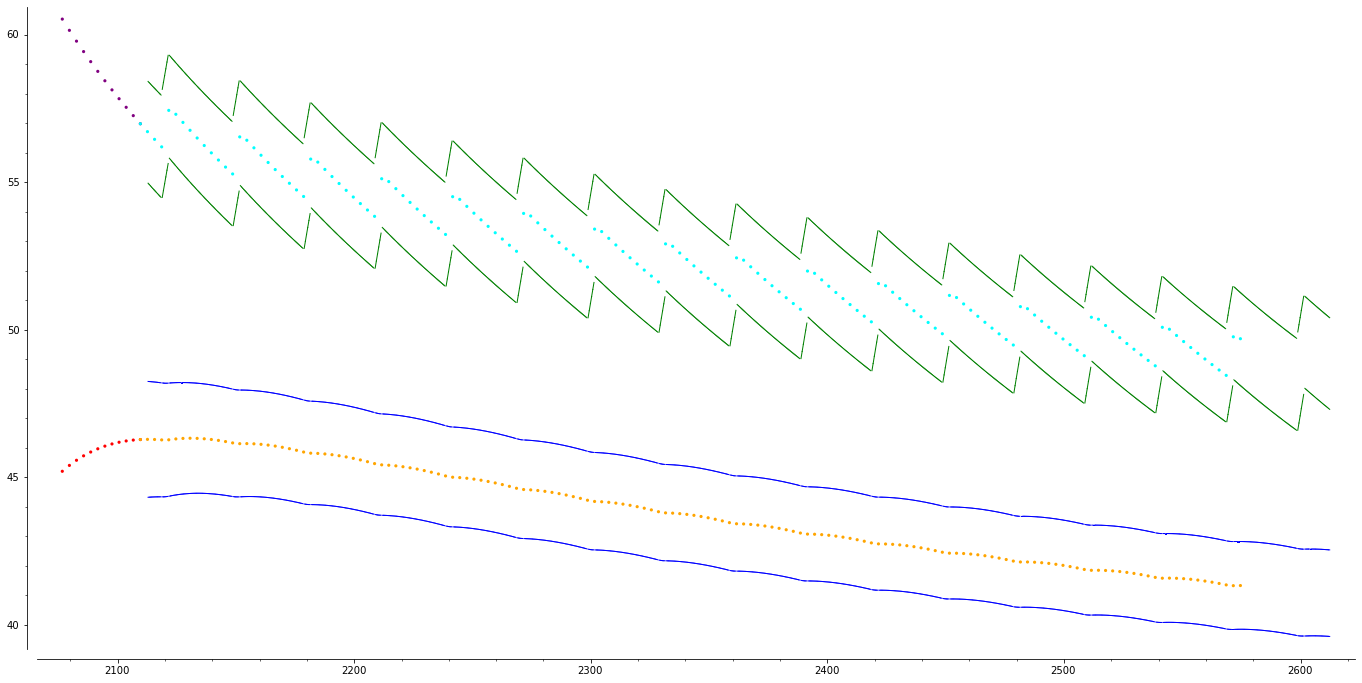

In [ ]:

m.self_adaptation_manager.state_machine.anomaly_durations[3]
(p4 + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T_heater'])
     if t
     in RIF(*m.self_adaptation_manager.state_machine.anomaly_durations[3])],
    color='purple',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T_heater'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[3][1],
            m.self_adaptation_manager.state_machine.anomaly_durations[3][0] + 500)],
    color='cyan',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T'])
     if t
     in RIF(*m.self_adaptation_manager.state_machine.anomaly_durations[3])],
    color='red',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[3][1],
            m.self_adaptation_manager.state_machine.anomaly_durations[3][0] + 500)],
    color='orange',
)
).matplotlib()

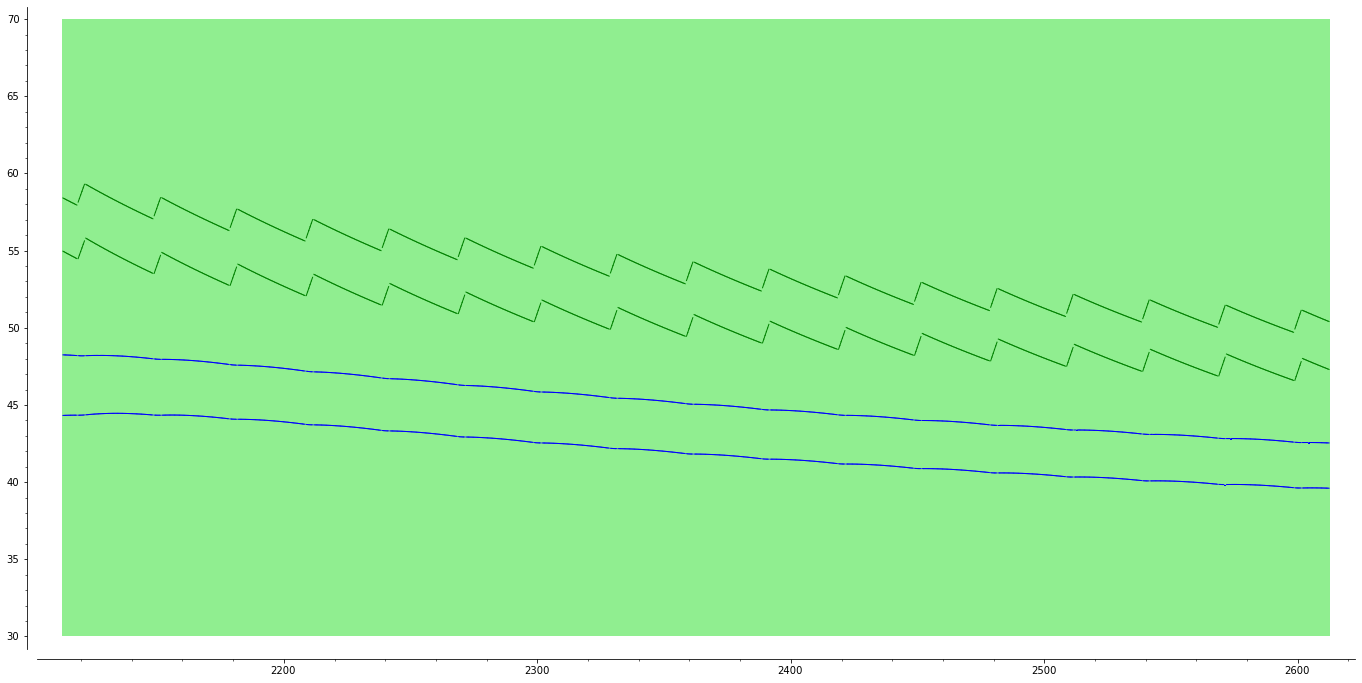

In [ ]:

p41 = (verified_sigs4[0].plot(y_range=(30, 70)) + p4)
p41.set_aspect_ratio('auto')
p41.matplotlib()


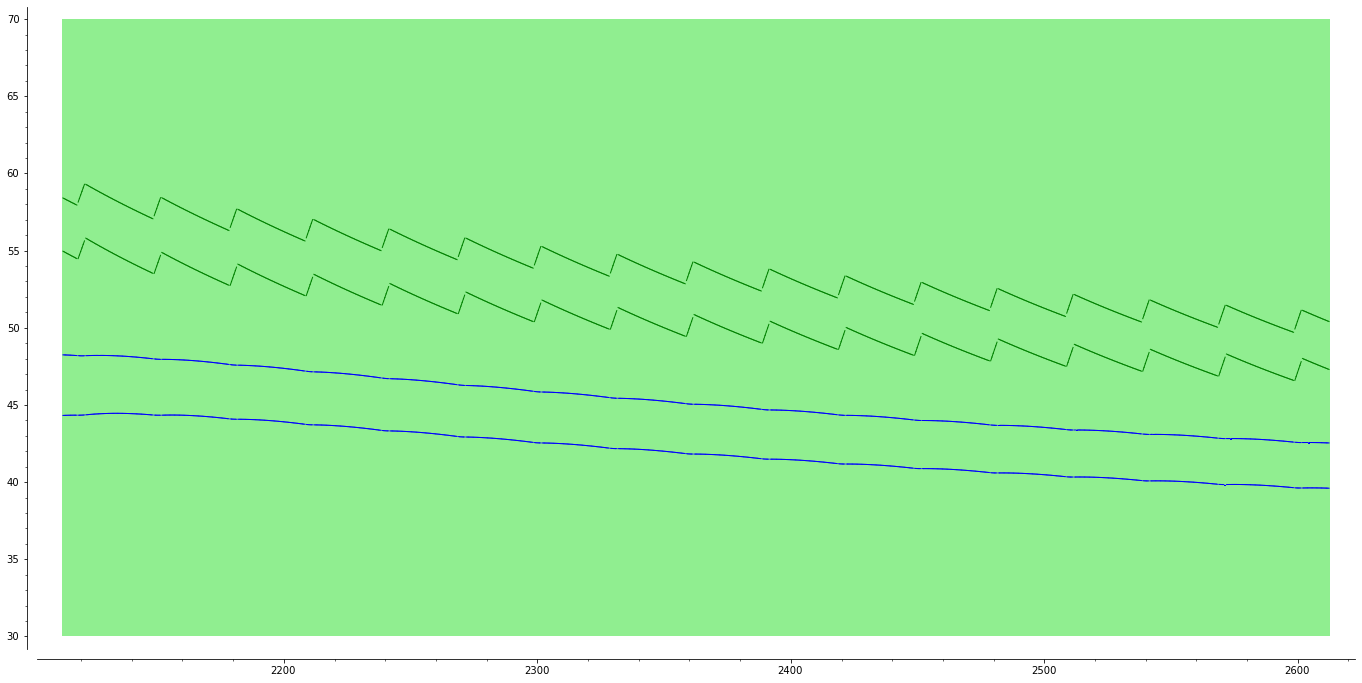

In [ ]:
p42 = (verified_sigs4[1].plot(y_range=(30, 70)) + p4)
p42.set_aspect_ratio('auto')
p42.matplotlib()


/home/sage/sage/local/lib/python3.9/site-packages/sage/plot/contour_plot.py:206: UserWarning: No contour levels were found within the data range.
  CS = subplot.contour(self.xy_data_array, contours, cmap=cmap,


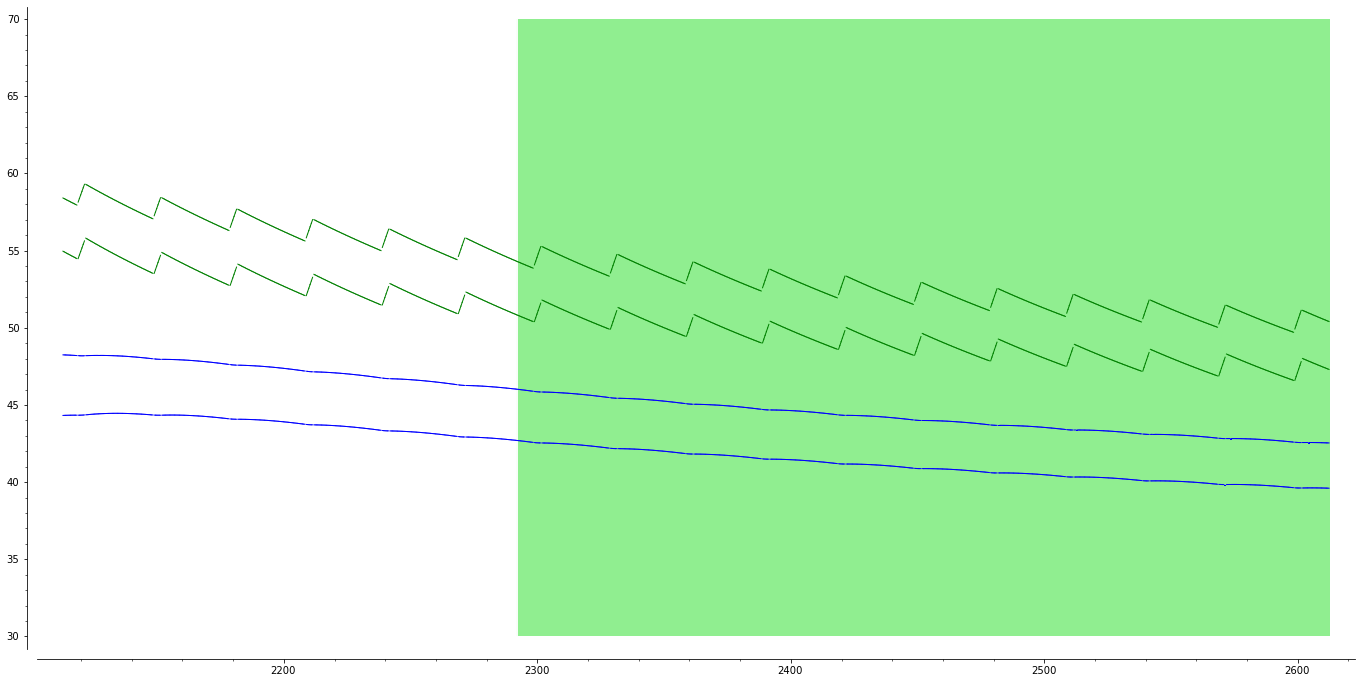

In [ ]:
p43 = (verified_sigs4[2].plot(y_range=(30, 70)) + p4)
p43.set_aspect_ratio('auto')
p43.matplotlib()

In [ ]:
F(RIF(0, 1000), G(RIF(0, 1000), verified_sigs4[2]))

F([0 .. 1000], G([0 .. 1000], Signal([2112.5938409201121 .. 2612.5938409201122], [([2291.9538409201145 .. 2291.9602215218193], True), ([2291.9638409201147 .. 2612.5938409201122], True)], mask=None)))

In [ ]:
m.self_adaptation_manager.state_machine.uncertainty_calibration_parameters
m.self_adaptation_manager.state_machine.anomaly_predicted_temperatures
m.self_adaptation_manager.state_machine.anomaly_real_temperatures

[40.89343413361608,
 40.803435217455856,
 40.73871379305887,
 40.734045186209215,
 40.78474185264556,
 40.88646379137607,
 41.03518939641186,
 41.20108342804741,
 41.34601857965197,
 41.471576450635816,
 41.57921916781574,
 41.6703018796663,
 41.77218934661789,
 41.92072006271307,
 42.11219201570815,
 42.34317876715041,
 42.610505557263615,
 42.885122145959244,
 43.12962889392269,
 43.346281920381266,
 43.5371686038274,
 43.70422367247779,
 43.875349128295944,
 44.08688145904817,
 44.33558026323977,
 44.61844698592553,
 44.93270348548921,
 45.249667156857576,
 45.53227912821347,
 45.7831113799731,
 46.00454406357157,
 46.198783277285465,
 46.39398255260561,
 46.626711514608374,
 46.89394584949581,
 47.19288728501423,
 47.520943310998625,
 47.84960337213895,
 48.141968056179365,
 48.4007571320135,
 48.62848772050194,
 48.82749286013707,
 49.026043725607785,
 49.260818966920056,
 49.52889530614443,
 49.8275681011161,
 50.154331606686995,
 50.48075566873323,
 50.77001537700981,
 51.024899

In [ ]:
m.supervisor.state_machine.supervisor_trigger_times

[1038.5938409201124, 2658.593840920112]